In [33]:
import numpy as np
import os
from torch.utils.data import Dataset
import librosa
import torch
import matplotlib.pyplot as plt
from torch import nn
import tqdm
import torchvision
from sklearn.metrics import roc_curve
import pandas as pd


from torchvision.models import resnet34

device =  'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using {device}")

Using cuda


In [34]:
def pad_random(x: np.ndarray, max_len: int = 64000):
    x_len = x.shape[0]
    if x_len > max_len:
        stt = np.random.randint(x_len - max_len)
        return x[stt:stt + max_len]

    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x, (num_repeats))
    return pad_random(padded_x, max_len)

class Singfake(Dataset):
    """
    Dataset class for the Singfake dataset.
    """
    def __init__(self, base_dir, partition="train", max_len=64000):
        assert partition in ["train", "val", "test_t01", "test_t02", "test_t04"], "Invalid partition. Must be one of ['train', 'val', 'test_t01', 'test_t02', 'test_t04']"
        self.base_dir = base_dir
        self.partition = partition
        self.base_dir = os.path.join(base_dir, partition + ".csv")
        self.max_len = max_len

        self.transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224))])

        df=pd.read_csv(self.base_dir)
        self.file_paths=list(df["file_path"])
        self.label=list(df["label"])



    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        bonafide_or_spoof = self.label[index]
        label = 1 if bonafide_or_spoof == "bonafide" else 0
        try:
            x, _ = librosa.load(os.path.join(self.base_dir, file_path), sr=16000, mono=True)
            x = pad_random(x, self.max_len) # x = pad_random (audio,64000)
            #x = librosa.util.normalize(x)
            #x = librosa.feature.melspectrogram(y=x, sr=16000)
            #x = librosa.feature.chroma_cqt(y=x,sr=16000)
            #x = np.abs(librosa.stft(x))
            x = librosa.feature.melspectrogram(y=x, sr=16000,hop_length=160,win_length=320,n_fft=320)
            x = librosa.amplitude_to_db(x,ref=np.max)
            #x = librosa.display.specshow(x, x_axis='time',
            #             y_axis='mel', sr=16000,
            #             fmax=8000)
            # file_name is used for generating the score file for submission
            #return self.transforms(torch.unsqueeze(torch.from_numpy(x),dim=0)), label, file_name
            return torch.unsqueeze(torch.from_numpy(x),dim=0), label, file_path

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None

In [35]:
train_ds=Singfake('/content/drive/MyDrive/Singfake/Labeled_dataset',partition='train')
val_ds=Singfake('/content/drive/MyDrive/Singfake/Labeled_dataset',partition='val')
t01_ds=Singfake('/content/drive/MyDrive/Singfake/Labeled_dataset',partition='test_t01')
t02_ds=Singfake('/content/drive/MyDrive/Singfake/Labeled_dataset',partition='test_t02')
t04_ds=Singfake('/content/drive/MyDrive/Singfake/Labeled_dataset',partition='test_t04')

In [36]:
print(len(train_ds))
print(len(t01_ds))

84404
43625


In [37]:
train_loader=torch.utils.data.DataLoader(train_ds,batch_size=16)
test_loader=torch.utils.data.DataLoader(t01_ds,batch_size=16)

torch.Size([1, 128, 401])


/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

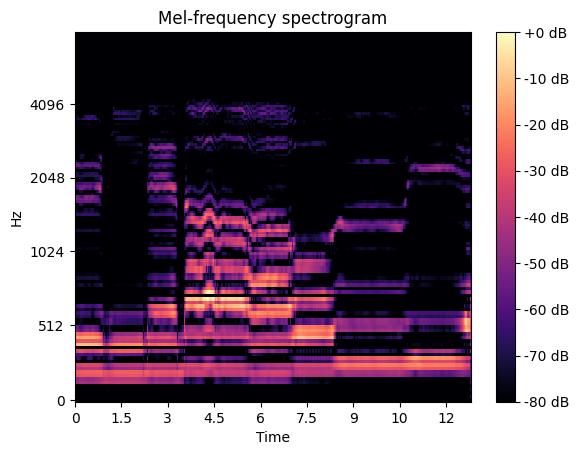

In [38]:
print(train_ds[0][0].shape)
fig, ax = plt.subplots()
img = librosa.display.specshow(np.asanyarray(train_ds[0][0][0]), x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [43]:
model=resnet34()

In [44]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
model.conv1=nn.Conv2d(1,64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
model.fc=nn.Linear(512,1)

In [46]:
with torch.inference_mode():
    print(model(torch.rand((1,1,128,401))))

tensor([[-0.1941]])


In [47]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

In [48]:
dt=next(iter(train_loader))
loss_fn=nn.BCEWithLogitsLoss()

with torch.inference_mode():
    x=dt[0]
    y=dt[1]
    logits=model(x)
    print(torch.sigmoid(logits).squeeze())
    print(y.type(torch.float32))
    print(loss_fn(logits.squeeze(),y.type(torch.float32)))

tensor([0.4375, 0.4714, 0.4541, 0.4692, 0.4525, 0.4333, 0.4652, 0.4778, 0.4772,
        0.4943, 0.4541, 0.4715, 0.4404, 0.4353, 0.4313, 0.4520])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(0.7832)


In [49]:
def train_model(model, epochs):
    model = model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters())
    loss_fn = nn.BCEWithLogitsLoss()

    for i in tqdm.notebook.tqdm(range(epochs)):
        train_preds = torch.tensor([], device=device)
        val_preds = torch.tensor([], device=device)
        train_actual = torch.tensor([], device=device)
        val_actual = torch.tensor([], device=device)
        
        print("\nTraining:")
        model.train()
        
        temp_train_loss = []
        temp_val_loss = []
    
        net_train_loss = 0
        net_val_loss = 0
        
        with tqdm.notebook.tqdm(total=len(train_loader)) as pbar:
            for x, y, _ in train_loader:
                x = x.to(device)
                y = y.to(device).type(torch.float32)

                logits = model(x)
        
                optimizer.zero_grad()
                loss = loss_fn(logits.squeeze(), y)
                
                preds = torch.sigmoid(logits).detach().squeeze()
                train_preds = torch.cat((train_preds, preds))
                train_actual = torch.cat((train_actual, y))
                
                temp_train_loss.append(loss.item())
                
                loss.backward()
                optimizer.step()
                
                pbar.update(1)
            pbar.close()
        
        net_train_loss = sum(temp_train_loss) / len(temp_train_loss)
    
        print("Testing:")
        model.eval()
    
        with tqdm.notebook.tqdm(total=len(test_loader)) as pbar2:
            for x, y, _ in test_loader:
                x = x.to(device)
                y = y.to(device).type(torch.float32)
                
                with torch.inference_mode():
                    logits = model(x)
                    loss = loss_fn(logits.squeeze(), y.type(torch.float32))
                    
                    preds = torch.sigmoid(logits).detach().squeeze()
                    val_preds = torch.cat((val_preds, preds))
                    val_actual = torch.cat((val_actual, y))
                    
                    temp_val_loss.append(loss.item())
    
                    pbar2.update(1)
            pbar2.close()
    
        net_val_loss = sum(temp_val_loss) / len(temp_val_loss)
        
        fpr, tpr, thresholds = roc_curve(val_actual.cpu().numpy(), val_preds.cpu().numpy())
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        
        print(f"\nEpoch {i+1}:\nTrain Loss: {net_train_loss}\nVal Loss: {net_val_loss}\nEER: {eer}\nEER Threshold: {eer_threshold}\n")


In [50]:
train_model(model,100)

  0%|          | 0/100 [00:00<?, ?it/s]


Training:


  0%|          | 0/5276 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),'epoch-100.pt')